## US Election 2020 Twitter Sentiment Analysis 

There are plenty of existing population polls trying to predict the outcome of a Presidential election. It would be of interest to perform ML sentiment analysis of a sample of past Twitter feeds (before it became X) to see how accurate it would be. Of course it begs the question if the sample population in Twitter has a diverse representation. On the other hand, the same can be said of the traditional polls and whether their samples are also diverse. 

#### Dataset 
I am using the [US Election 2020 Sample Dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data) from Kaggle for this analysis. It consists of two CSV files totaling about 1.7 million rows, one with Tweets focused on Joe Biden, and the other on Donald Trump. The dataset needs to be culled of Tweets originating outside of the US. While that doesn’t guarantee that non-US citizens in the US are Tweeting (or that citizens outside of the US are Tweeting) it helps narrow down any international opinions that would skew the results. The rest would be just data cleaning, for example, removing hashtags/mentions, URLs, and any extraneous text that is not generally readable and that may not convert to useful tokens. However, there some tools exist to help with data cleaning as well.

#### Tools 
As of late there are several publicly available LLMs that can assist with sentiment analysis, specifically on Twitter/X data. I'd like to explore the use of Hugging Face's [Twitter roBERTa-base Sentiment Analysis module](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). Additionally, the [distilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) and [sieBERT](https://huggingface.co/siebert/sentiment-roberta-large-english) models will be used to create an ensemble.

In [1]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import re   # regex for data cleaning
from tqdm import tqdm    # Shows progress bar for long tasks

# Hugging Face Modules
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertModel


# Allows for more efficent data processing
# by converting from DataFrame to Dataset
from datasets import Dataset    
import torch


---
### Data Wrangling
#### Reading in datasets

In [2]:
# Reading Trump Dataset 
trump = pd.read_csv("input/hashtag_donaldtrump.csv", lineterminator='\n')

In [3]:
# Reading Biden Dataset 
biden = pd.read_csv("input/hashtag_joebiden.csv", lineterminator='\n') 

---
#### Exploratory Data Analysis

Add a column to differentiate tweets from Trump and Biden datasets before we combine them.

In [4]:
# Create a new column 'candidate' to differentiate 
# between tweets of Trump and Biden upon concatination 
trump['candidate'] = 'trump'

# Biden dataframe 
biden['candidate'] = 'biden'

# Combine the dataframes 
tweets_df = pd.concat([trump, biden]) 
tweets_df = tweets_df.reset_index(drop=True)

# Final data shape 
print('Final Data Shape :', tweets_df.shape) 

Final Data Shape : (1747805, 22)


---
#### Data Cleaning and Wrangling

While this dataset has quite a number of null values depending on the column, let's see if we can maximize the useful data without dropping ALL rows with null values. First let's update all USA country fields to show "US". Then, find where the `user_location` is specified, but the `country` is not (`state_code` also is missing in many rows). We will focus on users where stated location is somewhere in the USA with the assumption that this will be part of our voting and/or influence group (even though there's no way to tell whether any user is a US citizen or not, and some users aren't even necessarily individuals but represent organizations, or even bots). Sometimes users will input a city and state (or even 'USA') in the `user_location` field which we may be able to parse even if the `country` field is null.

For easier manipulation, we will change rows with various `country` names for USA to just "US". 

In [5]:
# Shorten any United States (/of America) to simply "US"
tweets_df['country'] = tweets_df['country'].replace({'United States of America': "US",'United States': "US"}) 

Filter rows to show only tweets where country field is US.

In [6]:
# Isolate tweets where `country` is "US"
tweets_cntryUSA = tweets_df[tweets_df["country"] == "US"]

Filter full tweet DF for rows where `country` is null but `user_location` is set. This way we can try to parse out tweet user locations that are still in the USA.

In [7]:
# Check to see where user_location is available, but no country specified
tweets_loconly = tweets_df[tweets_df['country'].isnull() & 
                           tweets_df['user_location'].notnull()]

Parse `user_location` (again, where `country` is null) for US state abbreviations at the end.

In [8]:
# Read in list of US State abbreviations to parse user_location
states = pd.read_csv("support/states.csv", names=['states'])
statelist = states['states'].tolist()
print(statelist)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'USA']


In [9]:
# Filter the rows that have country as null but location as filled for those
# that have the last two characters matching a State abbreviation
user_states = tweets_loconly[tweets_loconly['user_location'].\
                             str[-2:].isin(statelist)]

Some `user_location` rows indicate "USA" so let's parse for that too.

In [10]:
# Check if user_location indicates "USA" if no state abbreviation at the end
user_stateUSA = tweets_loconly[tweets_loconly['user_location'].\
                               str.contains("USA", na=False)]

Let's combine `tweets_cntryUSA` with other parsed location-only tweets.

In [11]:
# Combine DFs with "US" country, and those with no country but US locations.
user_USAonly = pd.concat([tweets_cntryUSA, user_states, user_stateUSA]) 
user_USAonly = user_USAonly.reset_index(drop=True)

# Make sure to fill null 'country' fields with "US"
user_USAonly['country'] = user_USAonly['country'].fillna(value="US")
print(f"New size of filtered DF: {user_USAonly.shape}")

New size of filtered DF: (435522, 22)


Now we have a bit over 435 thousand tweets for our final sentiment dataset which includes users with stated locations in the USA.

In [12]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)           # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)              # Remove mentions (@username)
    tweet = re.sub(r'#', '', tweet)                 # Optional: remove '#' symbol (keep text)
    tweet = re.sub(r'\d+', '', tweet)               # Remove numeric IDs (optional)
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')  # Remove emojis/non-ASCII
    tweet = tweet.strip()                           # Remove leading/trailing spaces
    return tweet

In [13]:
user_USAonly['cleaned_tweets'] = user_USAonly['tweet'].apply(clean_tweet)

In [14]:
user_USAonly['cleaned_tweets'].sample(10)

275743                           Biden BidenHarrisLandslide
67936     Opinion: If Trump loses, he'll take this deal\...
28808     Guiliani asked this morning - What kind of a f...
355344    There's no way there's a real transition meeti...
182943    Dear CNN: Why are each of you giving credence ...
22118     Serious question.\nDo Biden supporters:\nA - n...
109775    What Can You Do If Trump Stages a Coup? | Citi...
424151    Poll: JOE BIDEN Continues to LEAD in Battlegro...
418494    Elections  ElectionResults  ElectionNight  Ele...
182101    House Minority Leader Kevin McCarthy echoed Tr...
Name: cleaned_tweets, dtype: object

Create a smaller sample size (20%) to run the ensemble model in reasonable amount of time based on limited compute.

In [ ]:
# Get smaller sample dataset for performance but make sure to keep
# both candidates represented equally.

seed = 42
frac_grp = 0.2

user_USAonly_sample = pd.concat([
    group.sample(frac=frac_grp, random_state=seed)
    for _, group in user_USAonly.groupby('candidate')
]).reset_index(drop=True)

In [16]:
user_USAonly_sample.shape

(87104, 23)

---
### Ensemble Sentiment Analysis

#### Hugging Face: Using an Ensemble of roBERTA, distilBERT, and sieBERT for sentiment analysis

The Hugging Faces models recommend converting our larger DataFrame directly to a Hugging Face Dataset for more efficient and native batch processing.

In [17]:
# Convert pandas DataFrame into Hugging Face Dataset
tweetUSA_dataset = Dataset.from_pandas(user_USAonly_sample)

#### Initialize roBERTa model

In [18]:
# Initialize roBERTa model

sentiment_roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0,             # GPU enabled
    truncation=True,      # Automatically truncates to max allowed tokens
    max_length=512        # Defaults to model's max tokens per tweet  
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


#### Initialize DistilBERT model and pipeline

In [ ]:
# Initialize DistilBERT model

distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
device = 0 if torch.cuda.is_available() else -1

distilBERT_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english",
    torch_dtype=torch.float16,
    attn_implementation="sdpa"  # Optimized attention
).to(device)

sentiment_distilbert = pipeline(
    "sentiment-analysis",
    model=distilBERT_model,
    tokenizer=distilbert_tokenizer,
    device=0,
    torch_dtype=torch.float16,  # GPU efficiency
)

Device set to use cuda:0


#### Initialize sieBERT model and pipeline

In [20]:
# Initialize SiEBERT model

model_siebert = "siebert/sentiment-roberta-large-english"

# Initialize the tokenizer and model
siebert_tokenizer = AutoTokenizer.from_pretrained(model_siebert)
siebert_model = AutoModelForSequenceClassification.from_pretrained(model_siebert)

# Set up the sentiment-analysis pipeline.
# Set device=0 if using a GPU; use device=-1 to run on CPU.
sentiment_siebert = pipeline(
    "sentiment-analysis",
    model=siebert_model,
    tokenizer=siebert_tokenizer,
    device=0  # Change to 0 if GPU is available
)

Device set to use cuda:0


#### Create Ensemble Analysis Function
Use all three models: RoBERTa, DistilBERT, and SieBERT to run through the data, then final sentiment is which two (or all three) models agree.

In [ ]:
# Ensemble Analysis Function

def analyze_ensemble_showmodels(batch):
    # Run batch inference for each model
    results_roberta = sentiment_roberta(batch["cleaned_tweets"])
    results_distilbert = sentiment_distilbert(batch["cleaned_tweets"])
    results_siebert = sentiment_siebert(batch["cleaned_tweets"])

    ensemble_sentiments = [] 
    ensemble_scores = []  # Sentiment Scores
    ensemble_voting = []  # Store sentiment "voting" information

    for i in range(len(batch["tweet"])):
        # Standardize labels to uppercase
        label_roberta = results_roberta[i]["label"].upper()
        label_distilbert = results_distilbert[i]["label"].upper()
        label_siebert = results_siebert[i]["label"].upper()
        
        # Filter out tweets where roBERTa returns NEUTRAL
        if label_roberta == "NEUTRAL":
            ensemble_sentiments.append(None)
            ensemble_scores.append(None)
            ensemble_voting.append(None)
            continue
        
        # Gather predictions from all three models
        predictions = [label_roberta, label_distilbert, label_siebert]
        
        # Majority vote logic: vote is the label that appears most
        vote = max(set(predictions), key=predictions.count)

        # For pure binary predictions (POSITIVE/NEGATIVE) this will 
        # always yield at least a 2-of-3 majority.
        final_sentiment = vote
        
        # Compute ensemble scores: average the scores of the models that agree with the majority vote.
        score_roberta = results_roberta[i]["score"]
        score_distilbert = results_distilbert[i]["score"]
        score_siebert = results_siebert[i]["score"]

        scores = [score_roberta, score_distilbert, score_siebert]

        maj_scores = [score for score, 
                      lab in zip(scores, predictions) if lab == vote]

        ensemble_score = sum(maj_scores) / len(maj_scores)
        
        # Determine which models contributed to the majority vote by concatenating their initials.
        vote_models = []
        if label_roberta == vote:
            vote_models.append("R")
        if label_distilbert == vote:
            vote_models.append("D")
        if label_siebert == vote:
            vote_models.append("S")
        voting_set = ''.join(vote_models)

        # Append the results to our lists
        ensemble_sentiments.append(final_sentiment)
        ensemble_scores.append(ensemble_score)
        ensemble_voting.append(voting_set)
    
    return {
        "ensemble_sentiment": ensemble_sentiments,
        "ensemble_score": ensemble_scores,
        "ensemble_votes": ensemble_voting
    }


In [22]:
# Apply the ensemble function in a batch-efficient manner.
result_dataset_showmodels = tweetUSA_dataset.map(
    analyze_ensemble_showmodels,
    batched=True,
    batch_size=32  # Adjust based on GPU memory/resources
)

Map:   0%|          | 0/87104 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [23]:
# Convert back to pandas DataFrame for data analysis
tweetUSA_sentiments_showmodels = result_dataset_showmodels.to_pandas()

In [24]:
# Save sentiment output
tweetUSA_sentiments_showmodels.to_csv("results/tweetUSA_sentiment_ensemble_models.csv")

Added new column `ensemble_votes` which shows which models agreed on their sentiment for the same tweet.
- R = RoBERTa
- D = DistilBERT
- S = SieBERT

In [32]:
# Check a sample of our tweets and sentiment data.
tweetUSA_sentiments_showmodels[['cleaned_tweets','candidate','ensemble_sentiment','ensemble_score','ensemble_votes']].sample(10)

,cleaned_tweets,candidate,ensemble_sentiment,ensemble_score,ensemble_votes
67933,y'all aren't biased at all lol every single pe...,trump,NEGATIVE,0.823942,RDS
21753,CHEYEAH biden has a long history of kindness,biden,POSITIVE,0.974883,RDS
77024,"Here's what America's ""essential workers"" must...",trump,NEGATIVE,0.941992,RDS
38064,has a SPECIAL REPORT coming at am. Biden has ...,biden,None,NaN,None
5732,"Joe Biden talking about issues, ideas and poli...",biden,POSITIVE,0.994281,RDS
57555,Respiratory Therapist - RT jobs job work hiri...,trump,None,NaN,None
15655,Remember when told NeverTrumpers how insignif...,biden,NEGATIVE,0.879563,RD
4322,. JoeBiden !!,biden,POSITIVE,0.804772,RS
59716,TrumpBackToHell Trump BidenToSaveUSA BidenPres...,trump,NEGATIVE,0.814278,RDS
84770,THENEXTNEWSNETWORK DONALDTTRUMPJR POST VIRAL V...,trump,NEGATIVE,0.840108,RDS


Drop rows that were not counted (i.e. sentiment or score is 'None' or 'NaN') because they were considered neutral by roBERTa.

In [34]:
tweetUSA_sentiments_modelsclean = tweetUSA_sentiments_showmodels.dropna(subset=['ensemble_score'])

In [35]:
tweetUSA_sentiments_modelsclean.shape

(54751, 26)

In [ ]:
# Check a sample of our tweets and cleaned sentiment data.
tweetUSA_sentiments_modelsclean[['cleaned_tweets','candidate','ensemble_sentiment','ensemble_score','ensemble_votes']].sample(10)

,cleaned_tweets,candidate,ensemble_sentiment,ensemble_score,ensemble_votes
62291,"You win Wisconsin ! Ur sen., is more embarras...",trump,NEGATIVE,0.955416,RDS
81461,TRUMPToSaveAmerica CheatingDemocrats STOPTHECO...,trump,NEGATIVE,0.976376,RDS
85154,"RT : DONALD TRUMP THEME SONG IS \n\n""WERE Y...",trump,NEGATIVE,0.845024,RDS
32246,"If American citizens really think that, the po...",biden,NEGATIVE,0.933241,RDS
25364,Yep JoeBiden,biden,POSITIVE,0.838297,RDS
11921,Being under Trump is like being married to an ...,biden,NEGATIVE,0.955855,RS
16358,crookedjoebiden\njoebiden\n\ntrumplandslide\nc...,biden,NEGATIVE,0.891596,RD
80552,I love JakeTapper \nLets all just face it. Tr...,trump,NEGATIVE,0.808553,RDS
10183,"""Trump refuses to concede, no plans to invite ...",biden,NEGATIVE,0.912500,RDS
17797,"Comunque vada, ne sar valsa la pena anche solo...",biden,POSITIVE,0.831142,RS


---
#### Plotting results

Counts of overall sentiments for each candidate:

In [39]:
print(tweetUSA_sentiments_modelsclean
      .groupby(['candidate'])['ensemble_sentiment']
      .value_counts()
      .unstack(fill_value=0))

ensemble_sentiment  NEGATIVE  POSITIVE
candidate                             
biden                  13862      9782
trump                  25291      5816


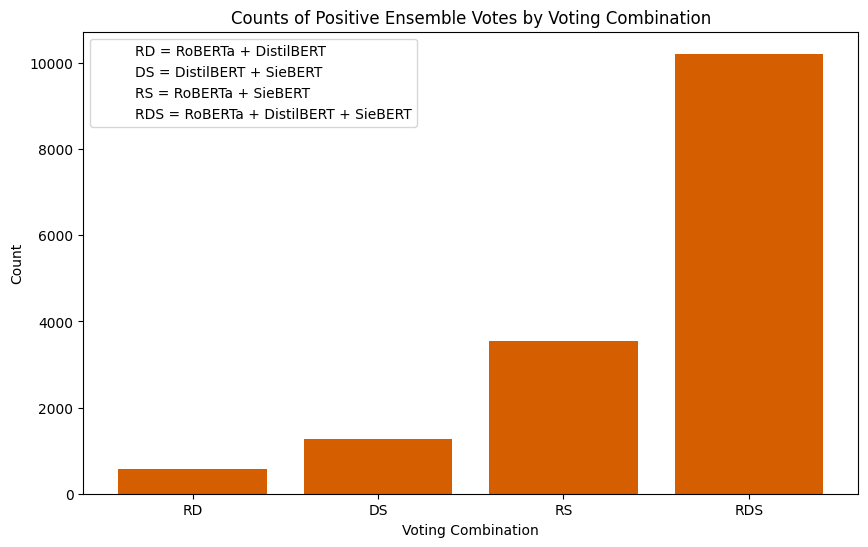

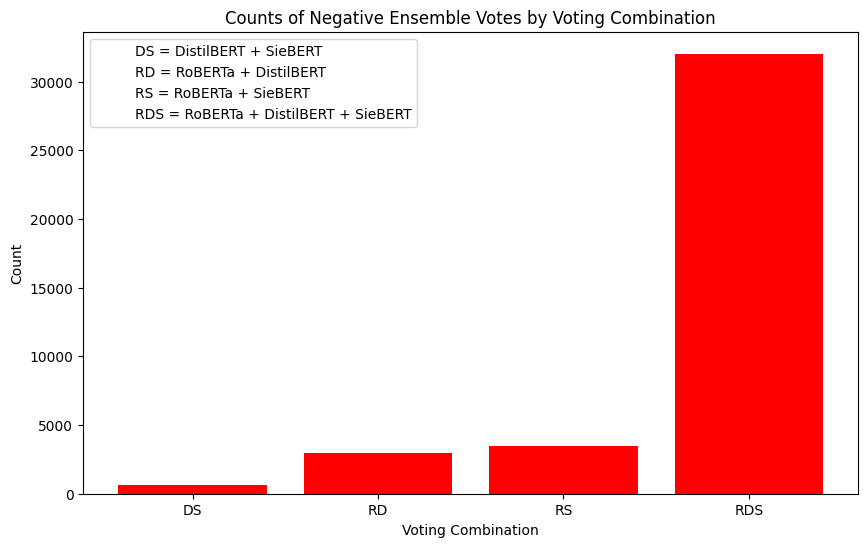

In [ ]:
from matplotlib.patches import Patch  # Provides for custom legends

# Sample voting mapping dictionary
voting_mapping = {
    "RDS": "RoBERTa + DistilBERT + SieBERT",
    "RS": "RoBERTa + SieBERT",
    "RD": "RoBERTa + DistilBERT",
    "DS": "DistilBERT + SieBERT",
    "R": "RoBERTa",
    "D": "DistilBERT",
    "S": "SieBERT"
}

# Create bar chart for Positive Votes
positive_df = tweetUSA_sentiments_modelsclean[
    tweetUSA_sentiments_modelsclean["ensemble_sentiment"] == "POSITIVE"]
positive_counts = positive_df["ensemble_votes"].value_counts().sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(positive_counts.index, positive_counts.values)
plt.xlabel("Voting Combination")
plt.ylabel("Count")
plt.title("Counts of Positive Ensemble Votes by Voting Combination")

# Build legend elements for positive chart
legend_elements = []
for code in positive_counts.index:
    label = voting_mapping.get(code, code)
    legend_elements.append(Patch(facecolor='none', 
                                 edgecolor='none', 
                                 label=f'{code} = {label}'))

plt.legend(handles=legend_elements, loc="upper left")
plt.show()

# Create bar chart for Negative Votes
negative_df = tweetUSA_sentiments_modelsclean[
    tweetUSA_sentiments_modelsclean["ensemble_sentiment"] == "NEGATIVE"]
negative_counts = negative_df["ensemble_votes"].value_counts().sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(negative_counts.index, negative_counts.values, color="red")
plt.xlabel("Voting Combination")
plt.ylabel("Count")
plt.title("Counts of Negative Ensemble Votes by Voting Combination")

# Build legend elements for negative chart
legend_elements = []
for code in negative_counts.index:
    label = voting_mapping.get(code, code)
    legend_elements.append(Patch(facecolor='none', 
                                 edgecolor='none', 
                                 label=f'{code} = {label}'))

plt.legend(handles=legend_elements, loc="upper left")
plt.show()

Normalized value counts

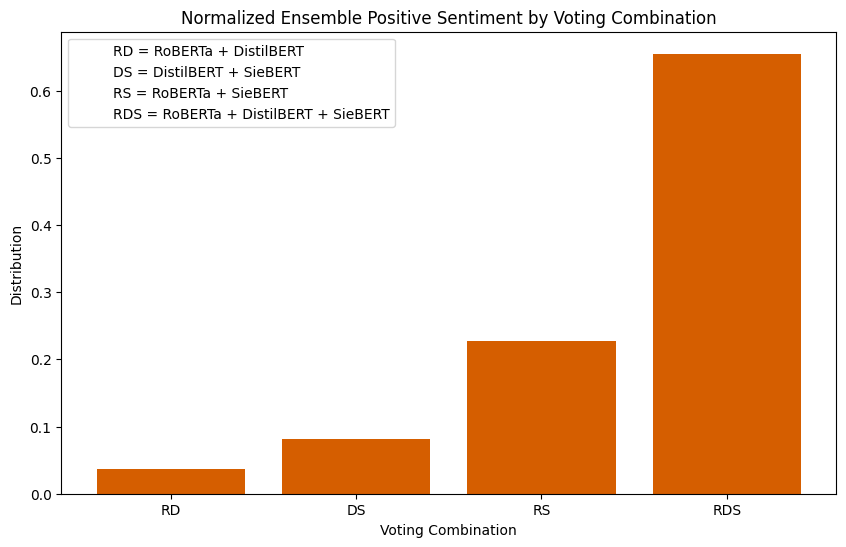

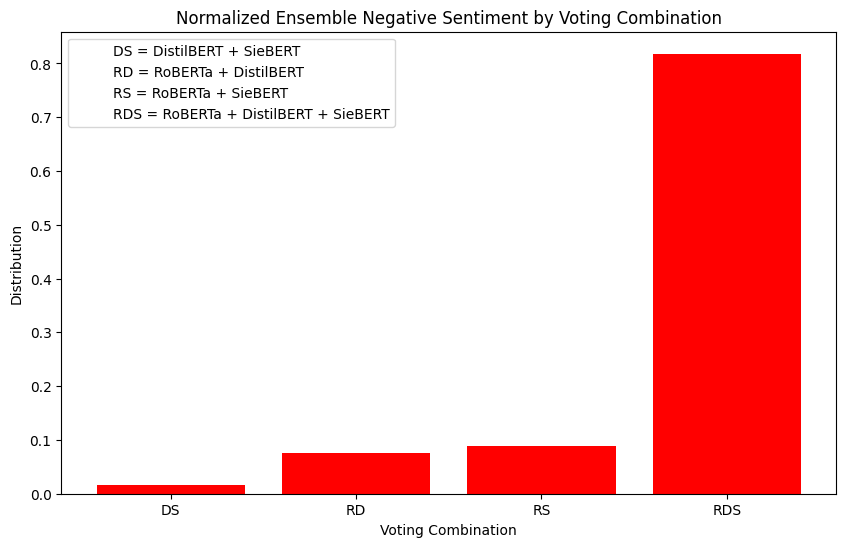

In [53]:
# Sample voting mapping dictionary
voting_mapping = {
    "RDS": "RoBERTa + DistilBERT + SieBERT",
    "RS": "RoBERTa + SieBERT",
    "RD": "RoBERTa + DistilBERT",
    "DS": "DistilBERT + SieBERT",
    "R": "RoBERTa",
    "D": "DistilBERT",
    "S": "SieBERT"
}

# Create bar chart for Positive Votes
positive_df = tweetUSA_sentiments_modelsclean[
    tweetUSA_sentiments_modelsclean["ensemble_sentiment"] == "POSITIVE"]
positive_counts = positive_df["ensemble_votes"]\
    .value_counts(normalize=True).sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(positive_counts.index, positive_counts.values)
plt.xlabel("Voting Combination")
plt.ylabel("Distribution")
plt.title("Normalized Ensemble Positive Sentiment by Voting Combination")

# Build legend elements for positive chart
legend_elements = []
for code in positive_counts.index:
    label = voting_mapping.get(code, code)
    legend_elements.append(Patch(facecolor='none', 
                                 edgecolor='none', 
                                 label=f'{code} = {label}'))

plt.legend(handles=legend_elements, loc="upper left")
plt.show()

# Create bar chart for Negative Votes
negative_df = tweetUSA_sentiments_modelsclean[
    tweetUSA_sentiments_modelsclean["ensemble_sentiment"] == "NEGATIVE"]
negative_counts = negative_df["ensemble_votes"]\
    .value_counts(normalize=True).sort_values()

plt.figure(figsize=(10, 6))
bars = plt.bar(negative_counts.index, negative_counts.values, color="red")
plt.xlabel("Voting Combination")
plt.ylabel("Distribution")
plt.title("Normalized Ensemble Negative Sentiment by Voting Combination")

# Build legend elements for negative chart
legend_elements = []
for code in negative_counts.index:
    label = voting_mapping.get(code, code)
    legend_elements.append(Patch(facecolor='none', 
                                 edgecolor='none', 
                                 label=f'{code} = {label}'))

plt.legend(handles=legend_elements, loc="upper left")
plt.show()

Show normalized tweet distribution by ensemble confidence score

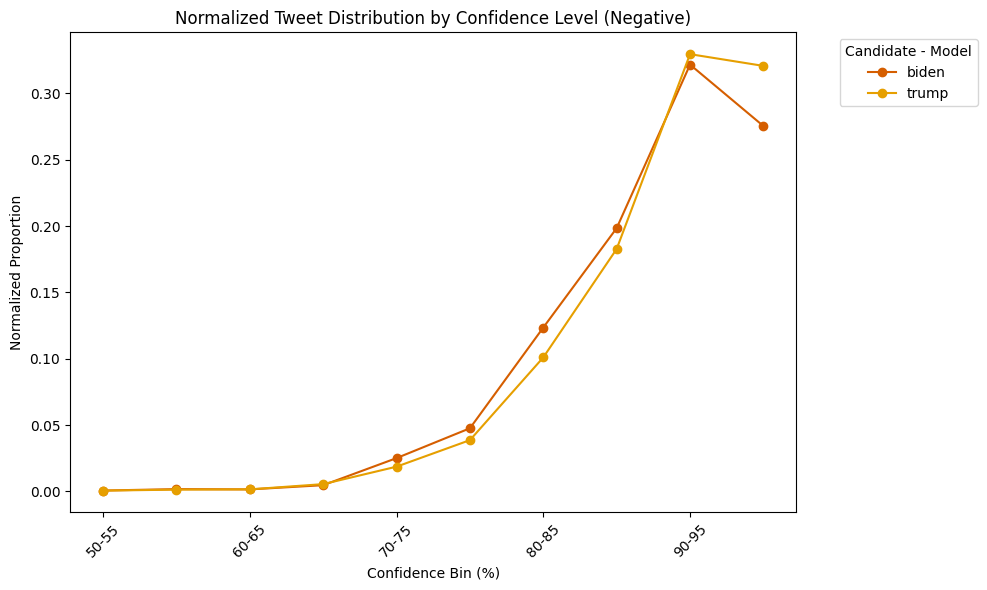

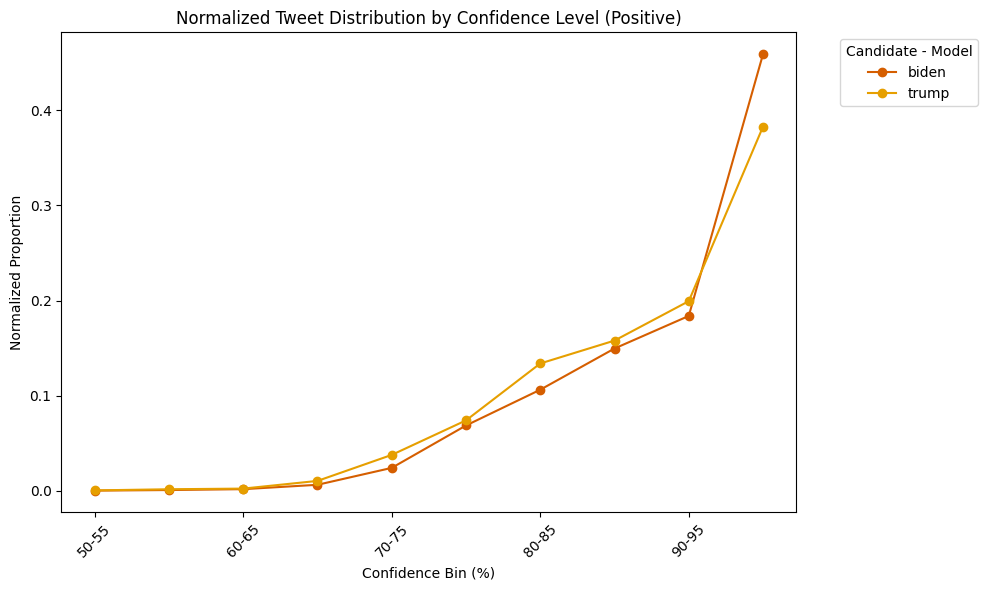

In [51]:
# Define confidence bins (from 50% to 100% in 5% increments)
bins = np.arange(0.50, 1.01, 0.05)
labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}" \
          for i in range(len(bins)-1)]

def plot_normalized_distribution_combined(df, bins, labels):
    # Filter for rows with clearly defined sentiments (positive or negative)
    df_filtered = df[df['ensemble_sentiment'].isin(['POSITIVE', 'NEGATIVE'])].copy()

    # Bin the sentiment_score values into the defined confidence ranges
    df_filtered['confidence_bin'] = pd.cut(
        df_filtered['ensemble_score'],
        bins=bins,
        labels=labels,
        right=False
    )

    # Group by candidate, model, sentiment, and confidence bin and count tweets
    grouped = (
        df_filtered
        .groupby(['candidate', 'ensemble_sentiment', 'confidence_bin'],
                 observed=True)
        .size()
        .reset_index(name='count')
    )

    # Normalize: for each candidate-sentiment group,
    # compute the proportion per confidence bin
    grouped['total'] = grouped\
        .groupby(['candidate',
                  'ensemble_sentiment'])['count']\
        .transform('sum')
    grouped['proportion'] = grouped['count'] / grouped['total']

    # Set up a high contrast color palette for the lines
    high_contrast_palette = ["#D55E00",
                             "#E69F00",
                             "#F0E442",
                             "#009E73",
                             "#0072B2",
                             "#CC79A7"]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=high_contrast_palette)

    # For each sentiment, pivot the data so that rows are confidence bins and
    # columns are cand_model, then plot the normalized proportions as a line chart.
    for sentiment in grouped['ensemble_sentiment'].unique():
        subset = grouped[grouped['ensemble_sentiment'] == sentiment]
        pivot = subset.pivot(index='confidence_bin',
                             columns='candidate',
                             values='proportion')
        pivot = pivot.sort_index()  # Ensure the confidence bins are in order

        ax = pivot.plot(marker='o', figsize=(10, 6), kind='line')
        ax.set_title(f"Normalized Tweet Distribution by Confidence Level ({sentiment.capitalize()})")
        ax.set_xlabel("Confidence Bin (%)")
        ax.set_ylabel("Normalized Proportion")
        plt.xticks(rotation=45)
        plt.legend(title='Candidate - Model',
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left')
        plt.tight_layout()
        plt.show()

plot_normalized_distribution_combined(tweetUSA_sentiments_modelsclean, bins, labels)

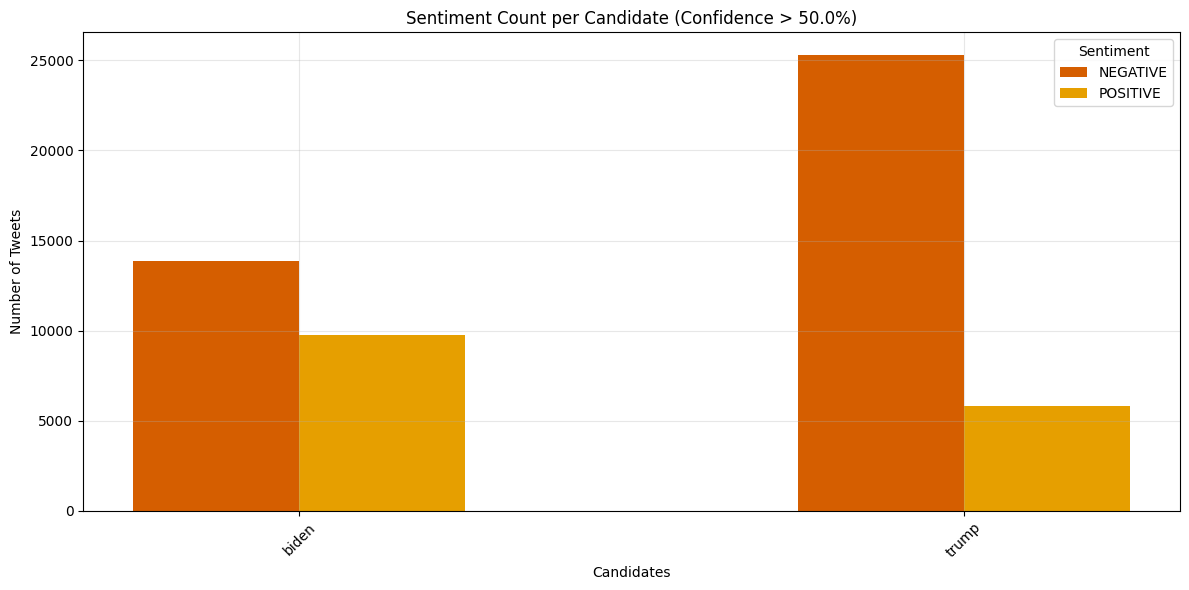

In [46]:
# Let's chart the data by tweet count
confidence = 0.5
sentiment_counts = (tweetUSA_sentiments_modelsclean[tweetUSA_sentiments_modelsclean['ensemble_score'] > confidence]
                   .groupby('candidate')['ensemble_sentiment']
                   .value_counts()
                   .unstack(fill_value=0))

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_counts.index
sentiments = sentiment_counts.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_counts[sentiment], 
            bar_width, 
            label=sentiment)

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Number of Tweets')
plt.title(f'Sentiment Count per Candidate (Confidence > {confidence * 100}%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

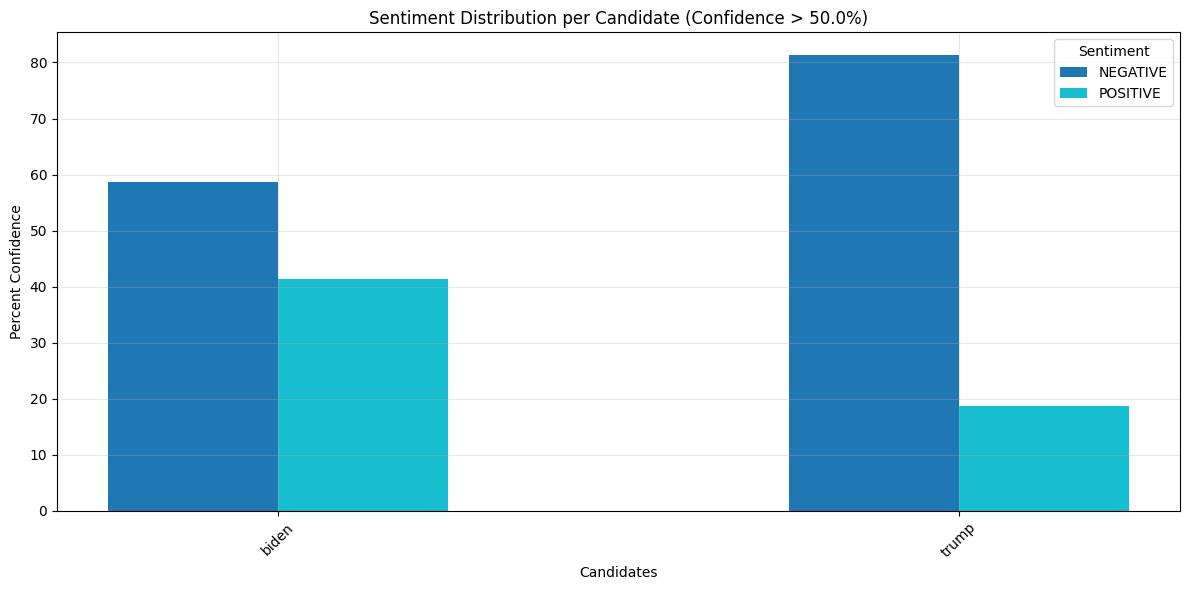

In [45]:
# Let's chart the normalized distribution with confidence > 50%
confidence = 0.5
sentiment_dist = (tweetUSA_sentiments_modelsclean[tweetUSA_sentiments_modelsclean['ensemble_score'] > confidence]
                  .groupby('candidate')['ensemble_sentiment']
                  .value_counts(normalize=True)
                  .unstack(fill_value=0) * 100)

# Create the plot
plt.figure(figsize=(12, 6))

# Get the candidates and sentiments
candidates = sentiment_dist.index
sentiments = sentiment_dist.columns
n_sentiments = len(sentiments)
bar_width = 0.25  # Width of each bar

# Set the positions of the bars
x = np.arange(len(candidates))

# Use a colormap
colors = plt.get_cmap('tab10', n_sentiments)  # 'tab10' gives distinct, high-contrast colors

# Plot bars for each sentiment with colormap colors
for i, sentiment in enumerate(sentiments):
    plt.bar(x + i * bar_width, 
            sentiment_dist[sentiment], 
            bar_width, 
            label=sentiment,
            color=colors(i))  # Get color from colormap

# Customize the plot
plt.xlabel('Candidates')
plt.ylabel('Percent Confidence')
plt.title(f'Sentiment Distribution per Candidate (Confidence > {confidence * 100}%)')
plt.xticks(x + bar_width * (n_sentiments-1)/2, candidates, rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

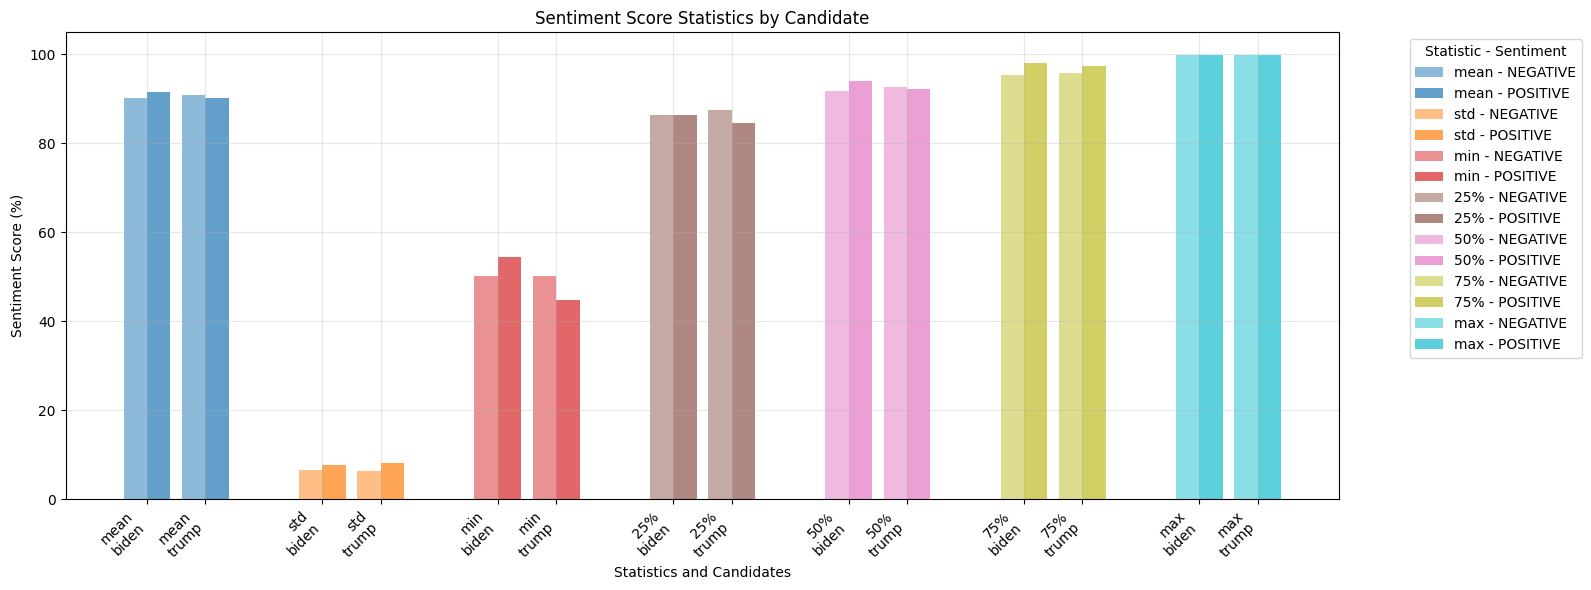

In [47]:
# Sentiment stats
sentiment_info = (tweetUSA_sentiments_modelsclean
                 .groupby(['candidate', 'ensemble_sentiment'])['ensemble_score']
                 .describe()
                 .unstack(fill_value=0) * 100)

# Drop 'count' in place
sentiment_info.drop('count', level=0, axis=1, inplace=True)

# Get candidates, sentiments, and stats
candidates = sentiment_info.index
sentiments = sentiment_info.columns.levels[1]  # negative, neutral, positive
stats_types = [col for col in sentiment_info.columns.levels[0] if col != 'count']  # Exclude 'count'
n_sentiments = len(sentiments)
n_stats = len(stats_types)
n_candidates = len(candidates)
bar_width = 0.2
candidate_gap = 0.1  # Small gap between candidates within a stat
stat_gap = 0.5  # Larger gap between statistic groups

# Create the plot
plt.figure(figsize=(16, 6))

# Use colormaps: one for stats
stat_colors = plt.get_cmap('tab10', n_stats)

# Plot bars for each statistic, candidate, and sentiment
for stat_idx, stat in enumerate(stats_types):
    stat_base = stat_idx * (n_candidates * n_sentiments * bar_width + n_candidates * candidate_gap + stat_gap)
    for cand_idx, candidate in enumerate(candidates):
        cand_base = stat_base + cand_idx * (n_sentiments * bar_width + candidate_gap)
        for i, sentiment in enumerate(sentiments):
            pos = cand_base + i * bar_width
            column_key = (stat, sentiment)
            # Label all sentiments for the first candidate per stat
            if cand_idx == 0:
                label = f'{stat} - {sentiment}'
            else:
                label = None
            plt.bar(pos,
                    sentiment_info.loc[candidate, column_key],
                    bar_width,
                    label=label,
                    color=stat_colors(stat_idx),
                    alpha=0.5 + i * 0.2)

# Customize the plot
plt.xlabel('Statistics and Candidates')
plt.ylabel('Sentiment Score (%)')
plt.title('Sentiment Score Statistics by Candidate')

# Create custom x-ticks centered under each candidate’s triplet
tick_positions = []
tick_labels = []
for stat_idx, stat in enumerate(stats_types):
    stat_base = stat_idx * (n_candidates * n_sentiments * bar_width + n_candidates * candidate_gap + stat_gap)
    for cand_idx, candidate in enumerate(candidates):
        cand_base = stat_base + cand_idx * (n_sentiments * bar_width + candidate_gap)
        tick_pos = cand_base + (n_sentiments * bar_width) / 2 - bar_width / 2  # Center under triplet
        tick_positions.append(tick_pos)
        tick_labels.append(f'{stat}\n{candidate}')

plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
plt.legend(title='Statistic - Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent cutoff
plt.tight_layout()

# Display the plot
plt.show()